## effect size sharing for multi-gene qtls

say we have a qtl that impacts multiple genes. How does the fractional effect of that qtl on each gene vary? w.r.t for instance distance from qtl to tss? maybe tie in ABC connections here? Maybe build a model that predicts how qtl impact on each gene will be split based on gene baseline expression, distance, ect

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
import scipy as sp

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = list(tissue_df['Tissue'])

# select just 1 tissue id to do for now 
my_tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type
#tissue_ids = [tissue_id]

### load in data
* effect sizes for qtls
* overlap dfs
* gencode for tss starts

In [3]:
cluster_df = load_cluster(config, my_tissue_id)

In [4]:
#chr_id = 2

cluster_df = load_cluster(config, my_tissue_id)
e_nominal = load_e_nominal_all_chr(config, my_tissue_id)
pc_nominal = load_pc_nominal_all_chr(config, my_tissue_id)
overlap = load_overlap(config, my_tissue_id)
pc_susie = load_pc_susie(config, my_tissue_id)

# set e_nominal to be index based on variant-cluster pairs
e_nominal_cid = e_nominal.set_index('var_cluster')


In [5]:
# look at just one chr to start
#pc_susie = pc_susie[pc_susie['cluster_id'].isin(high_cor_clusters)]
pc_susie['chr'] = pc_susie['variant_id'].str.split('chr').str[1].str.split('_').str[0]
#pc_nominal['chr'] = pc_nominal['variant_id'].str.split('chr').str[1].str.split('_').str[0]
#e_nominal['chr'] = e_nominal['variant_id'].str.split('chr').str[1].str.split('_').str[0]

#pc_susie = pc_susie[pc_susie['chr'] == f'{chr_id}']
len(pc_susie)

31905

take the subset of varaints in pcqtl determined credible sets, and calculate the varience-explained on a per gene basis for each gene in the cluster and for the cluster-pc overall

variance for each egene-cluster-credibleset(pc and cs num)

In [6]:
vid_pc_nominal = pc_nominal.set_index('variant_id')
vid_pc_nominal = vid_pc_nominal.loc[pc_susie['variant_id']]

vid_e_nominal = e_nominal.set_index('variant_id')
vid_e_nominal = vid_e_nominal.loc[pc_susie['variant_id']]

In [7]:
def add_variance(nominal_df):
    nominal_df['variance'] = nominal_df['slope'].apply(np.square) * 100

def get_var_explained(row, nominal_df):
    var_list = row['variant_id']
    pip_list = row['pip']
    # make sure all varaints are in the nominal df
    try:
        nominal_df['variance']
    except KeyError:
        add_variance(nominal_df)
    sub_nominal = nominal_df.loc[var_list]
    sub_nominal = sub_nominal[sub_nominal['cluster_id'] == row['cluster_id']]
    # add pips to the df    
    sub_nominal = sub_nominal.merge(pd.Series(pip_list, index=pd.Series(var_list, name='variant_id'), name='pip'), on='variant_id')
    sub_nominal['variance_weighted'] = sub_nominal['variance'] * sub_nominal['pip']
    # sum over each phenotype to get the total weighted varience
    return sub_nominal.groupby('phenotype_id').agg({'variance_weighted':'sum'}).reset_index()


def get_slope_pip_weighted(row, nominal_df):
    var_list = row['variant_id']
    pip_list = row['pip']
    # make sure all varaints are in the nominal df
    sub_nominal = nominal_df.loc[var_list]
    sub_nominal = sub_nominal[sub_nominal['cluster_id'] == row['cluster_id']]
    # add pips to the df    
    sub_nominal = sub_nominal.merge(pd.Series(pip_list, index=pd.Series(var_list, name='variant_id'), name='pip'), on='variant_id')
    sub_nominal['slope_weighted'] = sub_nominal['slope'] * sub_nominal['pip']
    # sum over each phenotype to get the total weighted varience
    return sub_nominal.groupby('phenotype_id').agg({'slope_weighted':'sum'}).reset_index()

In [8]:
# this is on the level of the credible set, so group the susie output by credible set
cs_grouped_pc_susie = pc_susie.groupby('cs_id').agg({'pip':list, 
                               'variant_id': list,
                               'cs_num':'first',
                               'pc_num':'first',
                               'lead_variant_id':'first',
                               'num_vars':'first',
                               'cluster_id':'first', 
                               'chr':'first'})

In [9]:
for idx, row in tqdm(cs_grouped_pc_susie.iterrows(), total=len(cs_grouped_pc_susie)):
    pc_slope_weighted = get_slope_pip_weighted(row, vid_pc_nominal)
    cs_grouped_pc_susie.loc[idx, 'matching_pc_slope'] = pc_slope_weighted[pc_slope_weighted['phenotype_id'].str.split('_pc').str[-1] == str(row['pc_num'])].iloc[0]['slope_weighted']

    e_var_weighted = get_slope_pip_weighted(row, vid_e_nominal)
    cs_grouped_pc_susie.loc[idx, 'e_slope'] = str(e_var_weighted['slope_weighted'].to_list())
    cs_grouped_pc_susie.loc[idx, 'e_slope_phenotypes'] = str(e_var_weighted['phenotype_id'].to_list())

  0%|          | 0/1675 [00:00<?, ?it/s]

In [10]:
cs_grouped_pc_susie['e_slope_max'] = [max(ast.literal_eval(e_slope), key=abs) for e_slope in cs_grouped_pc_susie['e_slope']]
cs_grouped_pc_susie['e_slope_average'] = [np.mean(ast.literal_eval(e_slope)) for e_slope in cs_grouped_pc_susie['e_slope']]

<AxesSubplot: xlabel='slope', ylabel='Count'>

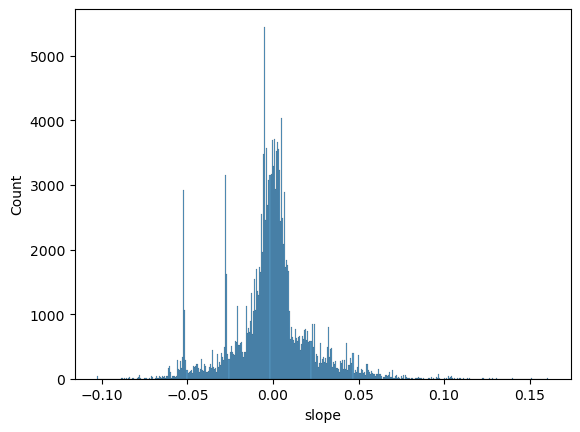

In [11]:
sns.histplot(vid_pc_nominal, x='slope')

Text(0.5, 0, 'pip weighted slope')

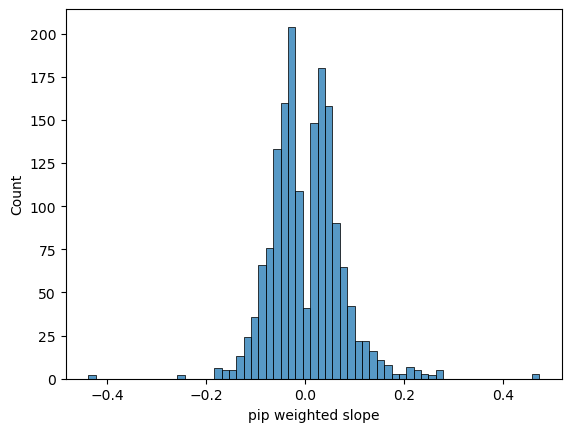

In [12]:
ax = sns.histplot(cs_grouped_pc_susie, x='e_slope_max')
plt.xlabel('pip weighted slope')


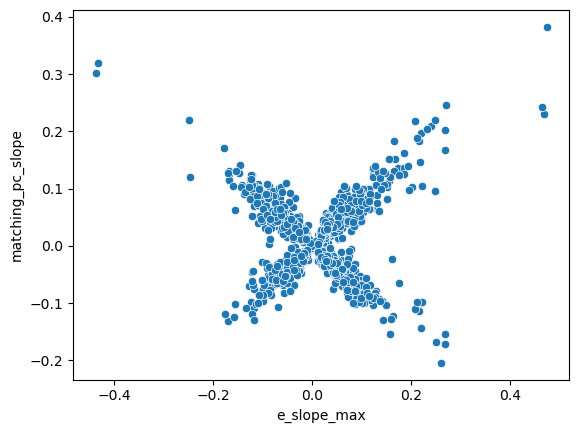

In [13]:
ax = sns.scatterplot(cs_grouped_pc_susie, x='e_slope_max', y='matching_pc_slope')


In [14]:
# add in credible set overlap information
overlap['cs_id'] = overlap['cs_full_id'].str.split('cs').str.join('')
annot_cs_grouped_pc_susie = pd.merge(cs_grouped_pc_susie, overlap[['num_e_samelead', 'num_pc_samelead', 'num_pc_overlap', 'num_e_overlap', 'cs_id', 'e_overlap']], on='cs_id', how='left')

# add in cluster info 
annot_cs_grouped_pc_susie = pd.merge(annot_cs_grouped_pc_susie, cluster_df[['Transcripts', 'Mean_pos_cor', 'Mean_neg_cor', 'cluster_id']], on='cluster_id', how='left')

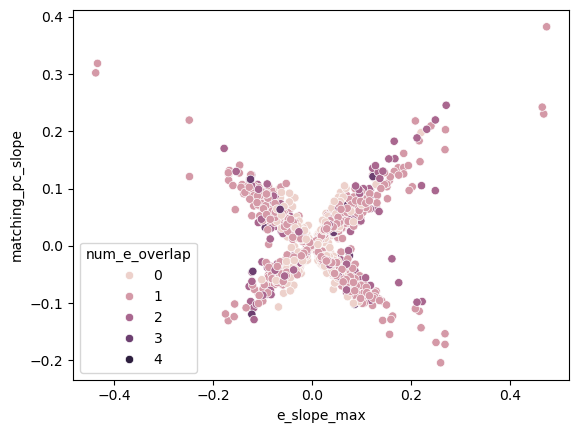

In [15]:
ax = sns.scatterplot(annot_cs_grouped_pc_susie, x='e_slope_max', y='matching_pc_slope', hue='num_e_overlap')

In [16]:
annot_cs_grouped_pc_susie['abs_cor'] = np.where(annot_cs_grouped_pc_susie['Mean_neg_cor'].isna(), annot_cs_grouped_pc_susie['Mean_pos_cor'], - annot_cs_grouped_pc_susie['Mean_neg_cor'])
annot_cs_grouped_pc_susie['abs_cor'] = np.where(annot_cs_grouped_pc_susie['abs_cor'] < annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['abs_cor'])

annot_cs_grouped_pc_susie['max_pos_neg_cor'] = np.where(annot_cs_grouped_pc_susie['Mean_neg_cor'].isna(), annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['Mean_neg_cor'])
annot_cs_grouped_pc_susie['max_pos_neg_cor'] = np.where(abs(annot_cs_grouped_pc_susie['max_pos_neg_cor']) < annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['max_pos_neg_cor'])


In [17]:
# filter to just high corr sets
# try filtering to say, only clusters with very high correlation
corr_cutoff = .3
cs_grouped_pc_susie_high_cor = annot_cs_grouped_pc_susie[annot_cs_grouped_pc_susie['abs_cor'] > corr_cutoff]
len(cs_grouped_pc_susie_high_cor)

1070

look at just those that impact multiple genes. are the genes more correlated?

<AxesSubplot: xlabel='max_pos_neg_cor', ylabel='Percent'>

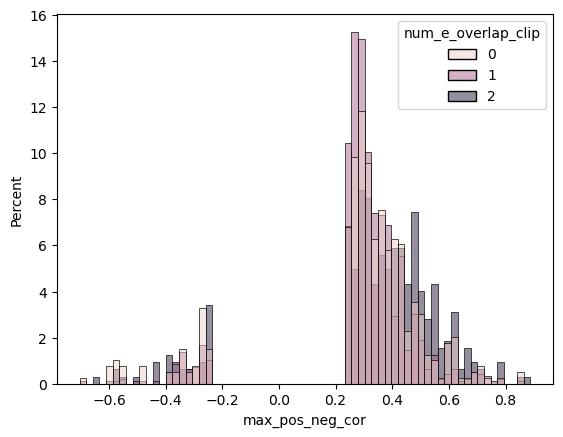

In [18]:
annot_cs_grouped_pc_susie['num_e_overlap_clip'] = annot_cs_grouped_pc_susie['num_e_overlap'].clip(0,2) 
sns.histplot(annot_cs_grouped_pc_susie, x='max_pos_neg_cor', hue='num_e_overlap_clip', common_norm=False, stat='percent')

## multigene comparisions
take those that are called as eqtls for multiple genes.
look at how the effect size for 1 gene changes the effect size for the other

In [19]:
multiegene_cs_grouped = annot_cs_grouped_pc_susie[annot_cs_grouped_pc_susie['num_e_overlap']>1].reset_index(drop=True)
len(multiegene_cs_grouped)

322

In [230]:
# look at the distribution of each slope vs the average slope. if an eqtl is shared, does it tend to impact all the genes roughly the same?

for idx, row in multiegene_cs_grouped.iterrows():
    egenes = [e_phenotype.split('_e_')[-1] for e_phenotype in ast.literal_eval(row['e_slope_phenotypes'])]
    sig_egenes = [e_phenotype.split('_e_')[1] for e_phenotype in ast.literal_eval(row['e_overlap'])]
    sig_egene_filter = pd.Series(egenes).isin(sig_egenes)
    sig_e_slope = np.asarray(ast.literal_eval(row['e_slope']))[sig_egene_filter]

    average_sig_slope = np.average(sig_e_slope)

    multiegene_cs_grouped.loc[idx, 'sig_slope'] = str(list(sig_e_slope))
    multiegene_cs_grouped.loc[idx, 'abs_sig_slope'] = str(list(abs(sig_e_slope)))

    multiegene_cs_grouped.loc[idx, 'average_sig_slope'] = average_sig_slope
    multiegene_cs_grouped.loc[idx, 'frac_average_slope'] = str(list(sig_e_slope/average_sig_slope))
    multiegene_cs_grouped.loc[idx, 'diff_average_slope'] = str(list(sig_e_slope - average_sig_slope))

    
multiegene_cs_grouped['sig_slope'] = multiegene_cs_grouped['sig_slope'].apply(ast.literal_eval)
multiegene_cs_grouped['abs_sig_slope'] = multiegene_cs_grouped['abs_sig_slope'].apply(ast.literal_eval)
multiegene_cs_grouped['frac_average_slope'] = multiegene_cs_grouped['frac_average_slope'].apply(ast.literal_eval)
multiegene_cs_grouped['diff_average_slope'] = multiegene_cs_grouped['diff_average_slope'].apply(ast.literal_eval)

<AxesSubplot: xlabel='sig_slope', ylabel='Percent'>

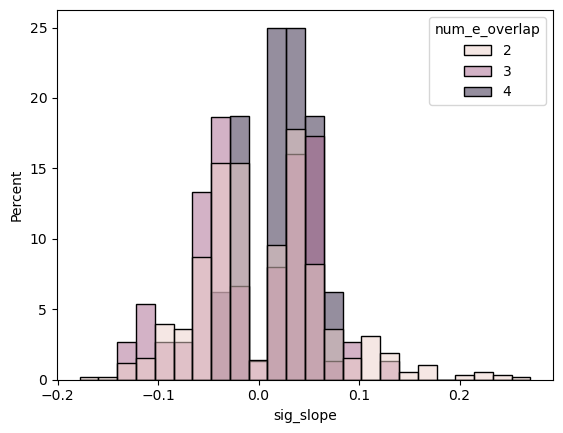

In [21]:
# plot the distribution of the fraction of average, colored by how many sig egenes the var has
sns.histplot(data = multiegene_cs_grouped.explode('sig_slope'), x='sig_slope', hue='num_e_overlap', common_norm=False, stat='percent')

I want to look at the fraction of average var vs the qtl-tss distance. I hypothesize the closer a qtl is to a gene, the larger the frac var will be. 

Should I include all vars in this? not just the signifigant ones??

In [231]:
gid_gencode, full_gencode = load_gencode()
multiegene_cs_grouped['lead_var_position'] = var_pos(multiegene_cs_grouped, column='lead_variant_id')

In [232]:
for idx, row in multiegene_cs_grouped.iterrows():
    sig_egenes = [e_var_phenotype.split('_e_')[1] for e_var_phenotype in ast.literal_eval(row['e_overlap'])]
    sig_egenes = pd.Series(sig_egenes).unique()
    sig_tss_starts = gid_gencode.loc[sig_egenes]['tss_start']
    multiegene_cs_grouped.loc[idx, 'num_sig_egenes'] = len(sig_egenes) # might be different from num_e_overlap if one egene has multiple cs
    multiegene_cs_grouped.loc[idx, 'sig_tss_starts']  = str(list(sig_tss_starts))
    multiegene_cs_grouped.loc[idx, 'sig_tss_var_distance']  = str(list(row['lead_var_position'] - sig_tss_starts))
    abs_distances = abs(sig_tss_starts - row['lead_var_position'])
    multiegene_cs_grouped.loc[idx, 'sig_tss_var_distance_abs']  = str(list(abs_distances))
    multiegene_cs_grouped.loc[idx, 'sig_tss_var_distance_diff']  = str(list(abs_distances - np.average(abs_distances)))
    multiegene_cs_grouped.loc[idx, 'sig_egenes'] = str(list(sig_egenes))
    


multiegene_cs_grouped['sig_tss_var_distance'] = multiegene_cs_grouped['sig_tss_var_distance'].apply(ast.literal_eval)
multiegene_cs_grouped['sig_tss_var_distance_abs'] = multiegene_cs_grouped['sig_tss_var_distance_abs'].apply(ast.literal_eval)
multiegene_cs_grouped['sig_tss_var_distance_diff'] = multiegene_cs_grouped['sig_tss_var_distance_diff'].apply(ast.literal_eval)
multiegene_cs_grouped['sig_egenes'] = multiegene_cs_grouped['sig_egenes'].apply(ast.literal_eval)

# drop those with multiple cs for the same egene 
multiegene_cs_grouped = multiegene_cs_grouped[multiegene_cs_grouped['num_sig_egenes'] > 1]
len(multiegene_cs_grouped)

321

In [233]:
multigene_egene_grouped = multiegene_cs_grouped.explode(['sig_tss_var_distance', 'frac_average_slope', 'sig_tss_var_distance_abs', 'sig_slope', 'diff_average_slope', 'sig_tss_var_distance_diff'])

In [234]:
# to start, look only at pairs as this is a bit easier to understand
pairegene_cs_grouped = multiegene_cs_grouped[multiegene_cs_grouped['num_sig_egenes'] == 2]


/local/scratch/klawren/slrmtmp.44606716/ipykernel_2047/861890256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairegene_cs_grouped['frac_slope'] = pairegene_cs_grouped['sig_slope'].str[0]/pairegene_cs_grouped['sig_slope'].str[1]


<AxesSubplot: xlabel='frac_slope', ylabel='Count'>

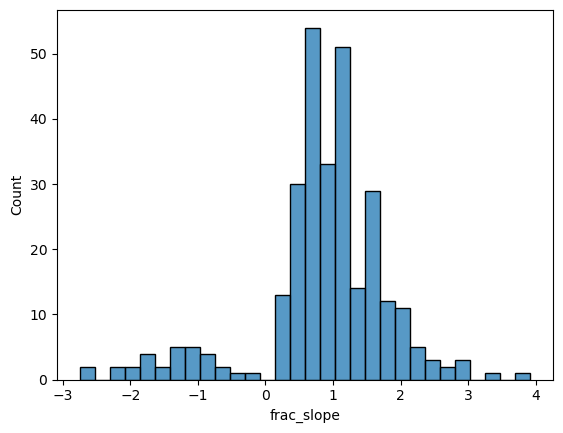

In [235]:
# dependent variable is fraction of slope
pairegene_cs_grouped['frac_slope'] = pairegene_cs_grouped['sig_slope'].str[0]/pairegene_cs_grouped['sig_slope'].str[1]
sns.histplot(pairegene_cs_grouped, x='frac_slope')

/local/scratch/klawren/slrmtmp.44606716/ipykernel_2047/558047866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairegene_cs_grouped['slope_gene_a'] = pairegene_cs_grouped['sig_slope'].str[0]
/local/scratch/klawren/slrmtmp.44606716/ipykernel_2047/558047866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairegene_cs_grouped['slope_gene_b'] = pairegene_cs_grouped['sig_slope'].str[1]


<AxesSubplot: xlabel='slope_gene_a', ylabel='slope_gene_b'>

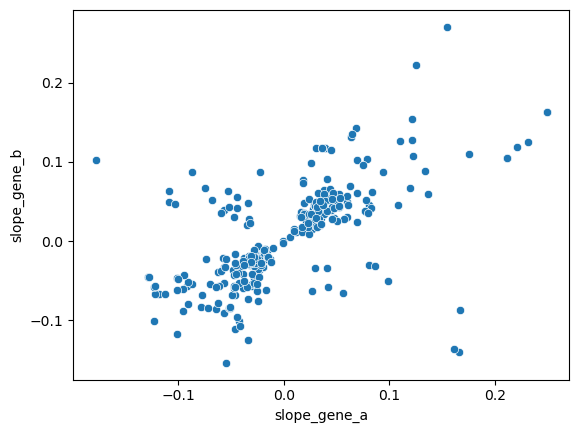

In [236]:
# indep variable is slope for A or B (i.e. mayber larger effect sizes more likely to be shared)
pairegene_cs_grouped['slope_gene_a'] = pairegene_cs_grouped['sig_slope'].str[0]
pairegene_cs_grouped['slope_gene_b'] = pairegene_cs_grouped['sig_slope'].str[1]
sns.scatterplot(pairegene_cs_grouped, x='slope_gene_a', y='slope_gene_b')

<AxesSubplot: xlabel='sig_tss_var_distance_abs', ylabel='abs_sig_slope'>

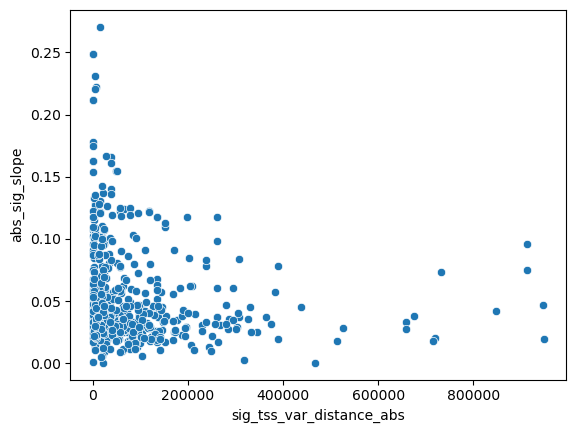

In [238]:
sns.scatterplot(pairegene_cs_grouped.explode(['sig_tss_var_distance_abs', 'abs_sig_slope']), x='sig_tss_var_distance_abs', y='abs_sig_slope')

In [244]:
pairegene_cs_grouped['dist_egene_a'] = pairegene_cs_grouped['sig_tss_var_distance_abs'].str[0]
pairegene_cs_grouped['dist_egene_b'] = pairegene_cs_grouped['sig_tss_var_distance_abs'].str[1]
pairegene_cs_grouped['dist_diff'] = pairegene_cs_grouped['dist_egene_a'] - pairegene_cs_grouped['dist_egene_b']
pairegene_cs_grouped['dist_frac'] = pairegene_cs_grouped['dist_egene_a']/pairegene_cs_grouped['dist_egene_b']
pairegene_cs_grouped['log_dist_frac'] = np.log10(pairegene_cs_grouped['dist_egene_a']) - np.log10(pairegene_cs_grouped['dist_egene_b'])

/local/scratch/klawren/slrmtmp.44606716/ipykernel_2047/3051772442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairegene_cs_grouped['dist_egene_a'] = pairegene_cs_grouped['sig_tss_var_distance_abs'].str[0]
/local/scratch/klawren/slrmtmp.44606716/ipykernel_2047/3051772442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairegene_cs_grouped['dist_egene_b'] = pairegene_cs_grouped['sig_tss_var_distance_abs'].str[1]
/local/scratch/klawren/slrmtmp.44606716/ipykernel_2047/3051772442.py:3: SettingWithCop

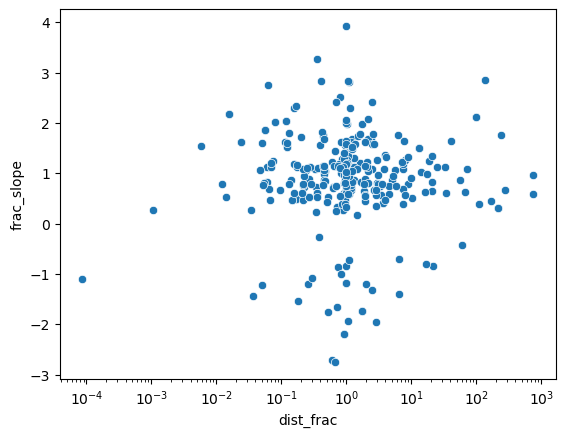

In [246]:
sns.scatterplot(pairegene_cs_grouped, x='dist_frac', y='frac_slope')
plt.xscale('log')

#### average expression

In [215]:
average_expression = pd.read_csv(f'{prefix}/data/processed/GTEx_Analysis_RSEMv1.gene_tpm.tissue_avg.csv', sep='\t', index_col=0)

/local/scratch/klawren/slrmtmp.44606716/ipykernel_2047/2523597067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairegene_cs_grouped['sig_egene_a'] = pairegene_cs_grouped['sig_egenes'].str[0]
/local/scratch/klawren/slrmtmp.44606716/ipykernel_2047/2523597067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairegene_cs_grouped['sig_egene_b'] = pairegene_cs_grouped['sig_egenes'].str[1]
/local/scratch/klawren/slrmtmp.44606716/ipykernel_2047/2523597067.py:4: SettingWithCopyWarning: 
A value is trying t

<AxesSubplot: xlabel='log_expression_gene_b', ylabel='slope_gene_b'>

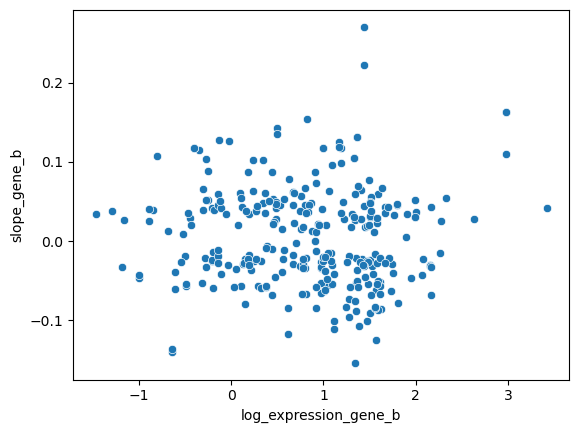

In [225]:
pairegene_cs_grouped['sig_egene_a'] = pairegene_cs_grouped['sig_egenes'].str[0]
pairegene_cs_grouped['sig_egene_b'] = pairegene_cs_grouped['sig_egenes'].str[1]

pairegene_cs_grouped['log_expression_gene_a'] = np.log10(average_expression.loc[my_tissue_id].loc[pairegene_cs_grouped['sig_egene_a']].values)
pairegene_cs_grouped['log_expression_gene_b'] = np.log10(average_expression.loc[my_tissue_id].loc[pairegene_cs_grouped['sig_egene_b']].values)

sns.scatterplot(pairegene_cs_grouped, x='log_expression_gene_b', y='slope_gene_b')

<AxesSubplot: xlabel='log_expression_gene_a', ylabel='log_expression_gene_b'>

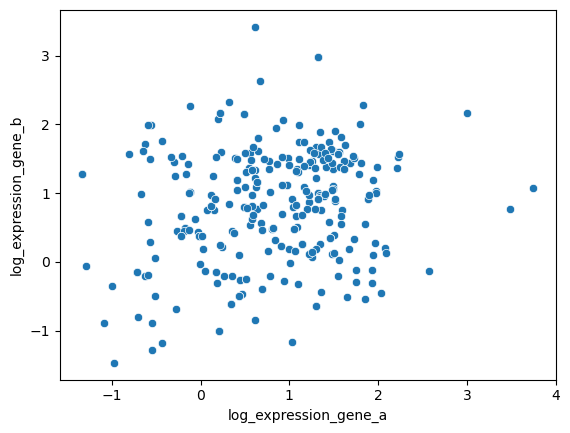

In [220]:
sns.scatterplot(pairegene_cs_grouped, x='log_expression_gene_a', y='log_expression_gene_b')

/local/scratch/klawren/slrmtmp.44606716/ipykernel_2047/1261452270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairegene_cs_grouped['expression_diff'] = pairegene_cs_grouped['log_expression_gene_a'] - pairegene_cs_grouped['log_expression_gene_b']


<AxesSubplot: xlabel='expression_diff', ylabel='frac_slope'>

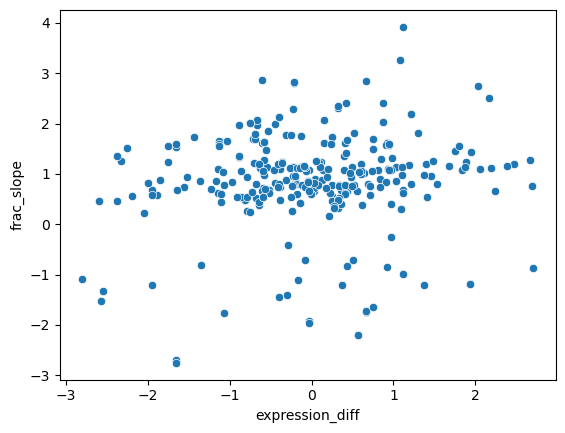

In [222]:
pairegene_cs_grouped['expression_diff'] = pairegene_cs_grouped['log_expression_gene_a'] - pairegene_cs_grouped['log_expression_gene_b']
sns.scatterplot(pairegene_cs_grouped, x='expression_diff', y='frac_slope')

## abc connection

In [248]:
gene_enhancer_df = load_abc(my_tissue_id)
gene_enhancer_df

,gene_name,TargetGene,enhancer,class,ABC.Score
transcript_id,,,,,
ENSG00000187634.11,SAMD11,SAMD11,intergenic|chr1:839603-841066,intergenic,0.022024
ENSG00000187634.11,SAMD11,SAMD11,intergenic|chr1:858775-859990,intergenic,0.038341
ENSG00000187634.11,SAMD11,SAMD11,promoter|chr1:859998-860794,promoter,0.110157
ENSG00000187634.11,SAMD11,SAMD11,genic|chr1:873422-874506,genic,0.019998
ENSG00000187634.11,SAMD11,SAMD11,genic|chr1:875493-876581,genic,0.027442
...,...,...,...,...,...
ENSG00000168939.11_PAR_Y,SPRY3,SPRY3,genic|chrX:153596915-153598726,genic,0.022562
ENSG00000168939.11_PAR_Y,SPRY3,SPRY3,promoter|chrX:154995885-154998520,promoter,0.315121
ENSG00000124333.15_PAR_Y,VAMP7,VAMP7,genic|chrX:153596915-153598726,genic,0.019883
